In [2]:
%pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------------- ------------------ 4.5/8.1 MB 24.4 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 28.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 20.1 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 18.3 MB/s  0:00:00

   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- -------

In [27]:

from pathlib import Path

def find_project_root(start: Path = Path.cwd(), marker="data", max_up=5) -> Path:
 
    p = start
    for _ in range(max_up):
        if (p / marker).exists():
            return p
        p = p.parent
    raise FileNotFoundError(f"Não encontrei a pasta '{marker}' acima de {start}. "
                            "Verifique a organização das pastas.")

ROOT = find_project_root()  
CLEAN_PATH = (ROOT / "data" / "processed" / "data_clean.csv").resolve()
FIG_DIR = (ROOT / "reports" / "figures").resolve()

print("ROOT      :", ROOT)
print("CLEAN_PATH:", CLEAN_PATH)
print("FIG_DIR   :", FIG_DIR)


FIG_DIR.mkdir(parents=True, exist_ok=True)


if not CLEAN_PATH.exists():
    raise FileNotFoundError(
        f"Arquivo não encontrado: {CLEAN_PATH}\n"
        "Dica: rode a Etapa01 (limpeza) para gerar o data_clean.csv, "
        "ou ajuste a estrutura para ter a pasta 'data/' na raiz do projeto."
    )


ROOT      : c:\DEV\Teste_Analytics_CristovamPaulo
CLEAN_PATH: C:\DEV\Teste_Analytics_CristovamPaulo\data\processed\data_clean.csv
FIG_DIR   : C:\DEV\Teste_Analytics_CristovamPaulo\reports\figures


data_clean.csv: C:\DEV\Teste_Analytics_CristovamPaulo\data\processed\data_clean.csv | mtime: 2025-10-05 00:05:13.286005735
vendas_2023.csv: C:\DEV\Teste_Analytics_CristovamPaulo\data\raw\vendas_2023.csv | mtime: 2025-10-04 21:01:04.911560297
Shape: (291, 7) | Produtos únicos: 30


,ID,Data,Produto,Categoria,Quantidade,Preco,Total
0,1,2023-08-13,Mouse Óptico,Eletrônicos,3,237.60,712.80
1,2,2023-10-12,Jogo De Tabuleiro,Brinquedos,2,194.12,388.24
2,3,2023-09-27,Camiseta Básica,Moda,4,115.94,463.76


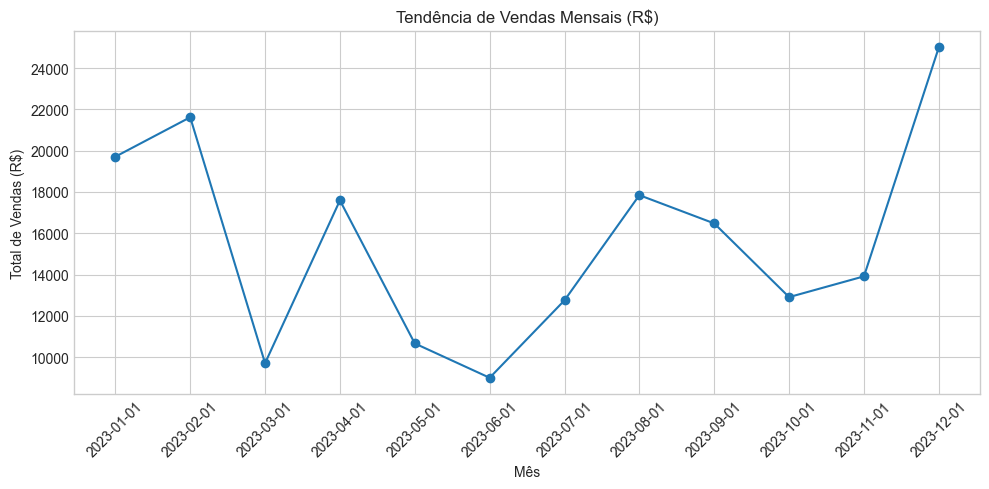

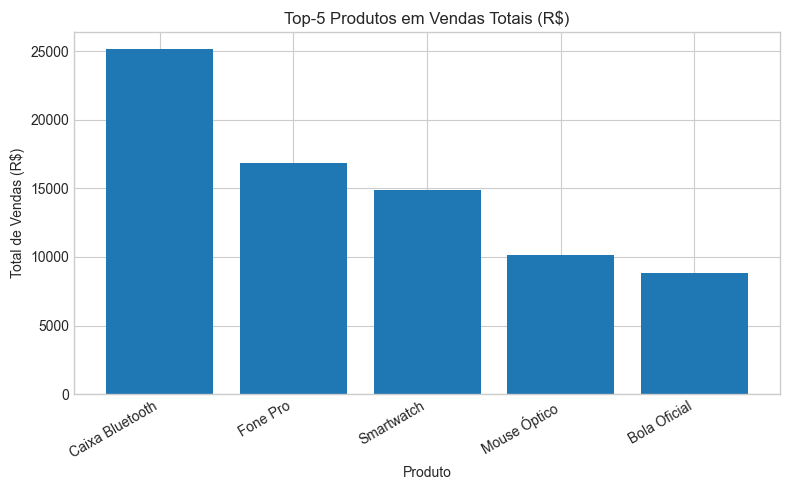

In [28]:
# ==== EDA: tendência mensal e top-5 produtos (robusto) ====
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

RAW_PATH = (ROOT / "data" / "raw" / "vendas_2023.csv").resolve()
if CLEAN_PATH.exists():
    m_clean = CLEAN_PATH.stat().st_mtime
    print("data_clean.csv:", CLEAN_PATH, "| mtime:", pd.to_datetime(m_clean, unit='s'))
else:
    raise FileNotFoundError(f"Arquivo não encontrado: {CLEAN_PATH}")
if RAW_PATH.exists():
    m_raw = RAW_PATH.stat().st_mtime
    print("vendas_2023.csv:", RAW_PATH, "| mtime:", pd.to_datetime(m_raw, unit='s'))
    if m_clean < m_raw:
        print("[AVISO] data_clean.csv é mais antigo que o raw. Reexecute a Etapa01 para atualizar os dados.")

# 1) Carregar dataset limpo SEM cache
_df = pd.read_csv(CLEAN_PATH)
if 'Data' in _df.columns:
    _df['Data'] = pd.to_datetime(_df['Data'], errors='coerce')
else:
    raise ValueError("Coluna 'Data' ausente no dataset limpo.")

_df["Quantidade"] = pd.to_numeric(_df.get("Quantidade"), errors="coerce").fillna(0).astype(int)
if "Preco_centavos" in _df.columns:
    _df["Preco_centavos"] = pd.to_numeric(_df["Preco_centavos"], errors="coerce").fillna(0).astype("Int64")
    _df["Total"] = ((_df["Quantidade"] * _df["Preco_centavos"]).astype("Int64") / 100).astype(float)
else:
    _df["Preco"] = pd.to_numeric(_df.get("Preco"), errors="coerce").fillna(0).astype(float)
    _df["Total"] = (_df["Quantidade"] * _df["Preco"]).astype(float)

print("Shape:", _df.shape, "| Produtos únicos:", _df["Produto"].nunique())
display(_df.head(3))

# 2) Tendência mensal
plt.close('all')
_mensal = _df.groupby(_df["Data"].dt.to_period("M"))['Total'].sum().astype(float).to_timestamp().reset_index()
plt.figure(figsize=(10,5))
plt.plot(_mensal['Data'].astype(str), _mensal['Total'], marker='o')
plt.title("Tendência de Vendas Mensais (R$)")
plt.xlabel("Mês")
plt.ylabel("Total de Vendas (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(str(FIG_DIR / 'tendencia_mensal.png'), dpi=120, bbox_inches='tight')
plt.show()

# 3) Top-5 produtos
_vendas_prod = (
    _df.groupby('Produto', as_index=False)['Total']
      .sum()
      .sort_values('Total', ascending=False)
      .head(5)
)
plt.figure(figsize=(8,5))
plt.bar(_vendas_prod['Produto'], _vendas_prod['Total'])
plt.title("Top-5 Produtos em Vendas Totais (R$)")
plt.ylabel("Total de Vendas (R$)")
plt.xlabel("Produto")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(str(FIG_DIR / 'top5_produtos.png'), dpi=120, bbox_inches='tight')
plt.show()


In [30]:
# ==== Resumo tabular de faturamento ====
# Totais mensais
_mensal_display = (
    _df.groupby(_df['Data'].dt.to_period('M'))['Total']
      .sum()
      .astype(float)
      .to_timestamp()
      .reset_index()
)
_mensal_display['Data'] = _mensal_display['Data'].dt.strftime('%Y-%m')
print('Faturamento mensal (R$):')
display(_mensal_display.rename(columns={'Total': 'Total_R$'}))

# Top-5 produtos por faturamento
_top5_table = (
    _df.groupby('Produto', as_index=False)['Total']
      .sum()
      .sort_values('Total', ascending=False)
      .head(5)
)
print('Top-5 produtos (faturamento em R$):')
display(_top5_table.rename(columns={'Total': 'Total_R$'}))

# Categorias em destaque em fevereiro/2023
_fevereiro_table = (
    _df[_df['Data'].dt.to_period('M') == pd.Period('2023-02', freq='M')]
      .groupby('Categoria', as_index=False)['Total']
      .sum()
      .sort_values('Total', ascending=False)
)
print('Categorias que mais venderam em fevereiro/2023:')
display(_fevereiro_table.rename(columns={'Total': 'Total_R$'}))


Faturamento mensal (R$):


,Data,Total_R$
0,2023-01,19706.82
1,2023-02,21617.00
2,2023-03,9707.27
3,2023-04,17590.81
4,2023-05,10663.76
5,2023-06,9000.85
6,2023-07,12752.57
7,2023-08,17844.73
8,2023-09,16476.35
9,2023-10,12907.68


Top-5 produtos (faturamento em R$):


,Produto,Total_R$
7,Caixa Bluetooth,25147.72
14,Fone Pro,16815.82
26,Smartwatch,14902.39
23,Mouse Óptico,10154.66
2,Bola Oficial,8818.55


Categorias que mais venderam em fevereiro/2023:


,Categoria,Total_R$
2,Eletrônicos,7630.34
3,Esporte,4962.71
0,Brinquedos,3532.05
1,Casa & Cozinha,2516.57
4,Material-Escolar,2267.70
5,Moda,707.63


# Insights Observados

- **Picos sazonais concentrados**: dezembro, fevereiro e janeiro somam aproximadamente R$ 66,3 mil (35% do faturamento de 2023), evidenciando o efeito combinado de férias, volta às aulas e temporada de fim de ano.
- **Dependência de eletrônicos de alto ticket**: o segmento responde por R$ 74,7 mil (40% do total). A Caixa Bluetooth gera R$ 25,1 mil e os cinco produtos líderes concentram 40,5% da receita.
- **Fevereiro sustentado por tecnologia e material escolar**: eletrônicos representam 35% das vendas do mês (R$ 7,6 mil) e Material Escolar adiciona 10,5% (R$ 2,3 mil), explicando o pico observado na tendência mensal.
- **Categorias intermediárias sustentam o miolo do ano**: Casa & Cozinha (R$ 29,3 mil), Esporte (R$ 28,5 mil) e Brinquedos (R$ 23,8 mil) mantêm o giro dos meses medianos e merecem campanhas dedicadas.
- **Meses de baixa acentuada**: junho (R$ 9,0 mil) e março (R$ 9,7 mil) ficam abaixo de R$ 10 mil; ações promocionais nesses períodos ajudam a suavizar a curva anual.

